In [1]:
import os
# Disable tokenizers parallelism
# os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'      


In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-kps3vign
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-kps3vign
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=92b787de4ae31bffc9a7b7c044a1cb483e3c989bcdd4722310f9730d909ad37c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lo5daj8/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=em

In [3]:
import pandas as pd
from collections import Counter
import re
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
from datasets import load_metric
import datasets
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from datasets import Dataset, DatasetDict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import random
np.object = object
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding,BertModel,AutoTokenizer,AutoConfig,RobertaModel
from collections import defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from sklearn.model_selection import KFold
from torch.cuda import amp

import gc
gc.enable()

2025-02-25 15:25:51.083661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 15:25:51.083807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 15:25:51.221187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_csv("/kaggle/input/bengali-pharmaceutical-reviews/LargePharmaVal.csv")

In [6]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=10))

,Reviews,category,Label,Length,Word Count
3116,এই প্রাইজে বেশি কিছু আশা করার মতো না। তাই যা পেয়েছি তা নিয়েই খুশি আছি। তবে একটা অনুরোধ আমার ডেলিভারি একটু আগে আগে দিয়েন। \nআমার একটু ঝামেলা হয় আপনারা যেভাবে একটু দেরী করেন।,medical_kits,4,172,33
2902,"সুন্দর প্যাকেজিং করে দিয়েছে! খুবই প্রিমিয়াম প্রোডাক্ট 😍, খুব উন্নত মানের প্রোডাক্ট। যে কেউ চোখ বন্ধ করে অর্ডার করতে পারেন 💝",medicines,5,125,21
1374,বাজে অভিজ্ঞতা। মালিশের তেল সিল ভাঙ্গা 🤬🤬 পরিমাণ কম সেলার একদম অসৎ,medicines,1,65,12
5028,এই মালিশের তেল নিয়ে মিক্স ফিলিংস। সাইজটা ছোট মনে হয়,medicines,2,53,10
4900,"প্রথমের দিকে ২ বার কিনেছিলাম। এখন একদম চিপ কোয়ালিটি হয়ে গেছে, আর ৫ টা লোকাল শ্যাম্পুর মতই হয়ে গেছে। দাম আগের মতোই বেশি রেখেছে।",womens_item,2,128,24
5807,না এগুলো মানা যায় না খানকির চোদা। তোদের হোগা দিয়ে ভরে দিবো এই কনডম শাউয়ার ছেলে কোথাকার 🤬🤬। করতে গেলে ফেটে যায় আবাল বালের মাল দিলি শালা।,adult_items,1,136,27
6808,স্যানিটারি আইটেম অর্ডার ছিলো গত ১০ দিন আগে। আর্জেন্ট ডেলিভারিতে দিয়েছিলাম। কিন্তু ডেলিভারি সিস্টেম এতো ধীরগতির যে এখনো ২টি প্রডাক্ট আসে নি। প্রতারক সেলারের কাছে টাকা দিলাম কিনা আল্লাহ জানেন! আমি ভয়ে আছি আমার কিছু কাস্টমার আমাকে কল দিয়ে বারবার বকা দিচ্ছেন। আমাকে বাটপার ভাবছেন। এদের জন্য মান ইজ্জত সব হারাতে হবে দেখছি। খুব নিম্নমানের সার্ভিস বলতেই হচ্ছে।,womens_item,1,354,58
1321,অনেকটাই ঠিক আছে। তেল এর মোটামুটি ঠিক আছে,body_fitness,3,40,8
302,দাম অনুযায়ী মাস্ক ঠিক আছে। মান মোটামুটি ভালো,medical_kits,3,45,8
6522,প্যাকেট খোলা ছিল এনার্জি পাউডার এর। নষ্ট মাল মনে হচ্ছে । এটা কেন হয়েছে জবাব চাই 🤬🤬,Random/Misc,1,82,17


In [7]:
df.shape

(9515, 5)

In [8]:
df.shape[0]*0.7

6660.5

In [9]:
df["Label"].value_counts()

Label
5    2238
1    2199
4    1989
2    1563
3    1526
Name: count, dtype: int64

In [10]:
df["Label"] = df["Label"] - 1  # Shift labels to be zero-indexed
df["Label"].value_counts()

Label
4    2238
0    2199
3    1989
1    1563
2    1526
Name: count, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(df))
    ax = sns.countplot(x=col,  data=df, order = df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

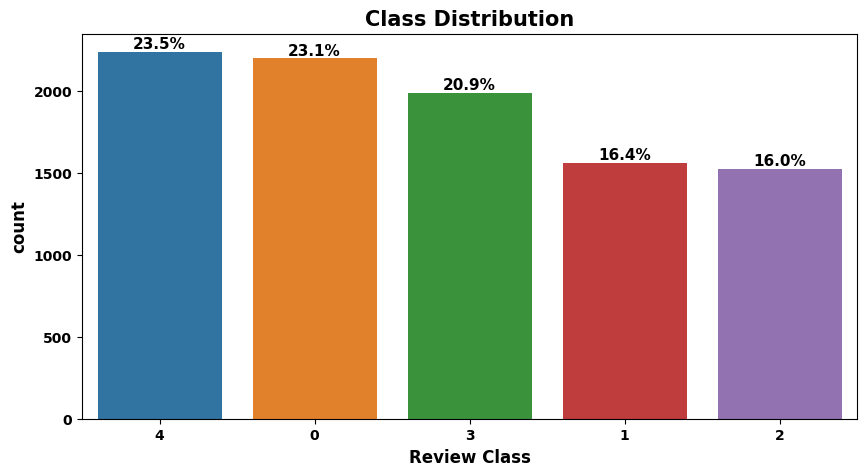

In [12]:
countplot(10,5,'Label',15,0,'Review Class','Class Distribution')

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test1, y_train, y_test1 = train_test_split(df['Reviews'], df['Label'], test_size=0.3, random_state=42, stratify=df['Label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42, stratify=y_test1)

In [14]:
X_train.shape

(6660,)

In [15]:
train_df = pd.DataFrame()
train_df['text'] = X_train.values
train_df['label'] = y_train.values


In [16]:
val_df = pd.DataFrame()
val_df['text'] = X_val.values
val_df['label'] = y_val.values

In [17]:
test_df = pd.DataFrame()
test_df['text'] = X_test.values
test_df['label'] = y_test.values

In [18]:
train_df.shape

(6660, 2)

In [19]:
train_df.head()

,text,label
0,১০০% অরিজিনাল প্রোডাক্ট! খুব উন্নত মানের প্রোড...,4
1,আলহামদুলিল্লাহ অনেক অনেক ভালো লেগেছে 😍। সুন্দর...,4
2,প্রথম প্রথম ব্যবহার করে খুব ভালো ফল পেয়েছিলাম ...,2
3,অসংখ্য ধন্যবাদ সেলারকে। তিনি কারেন্ট ডেটের এবং...,4
4,৫০ টা মাস্কের অনেক গুলায় নাকে ফিট করার স্টিল ট...,2


In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1428 non-null   object
 1   label   1428 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    ax = sns.countplot(x=col,  data=train_df, order = train_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

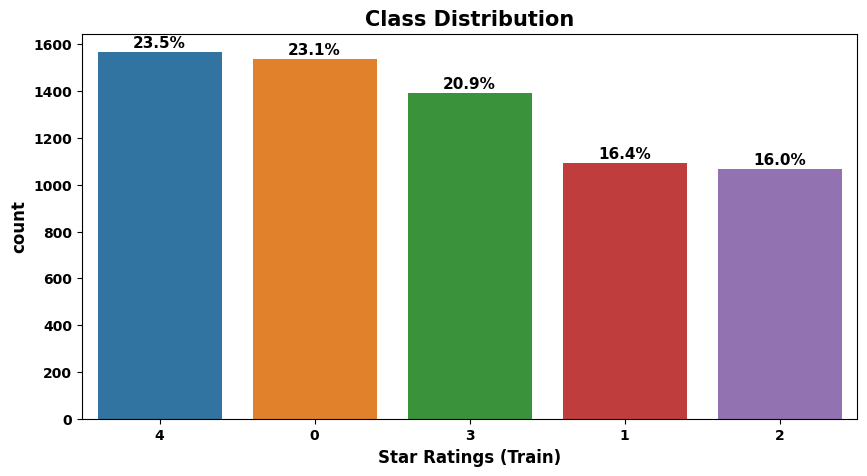

In [22]:
countplot(10,5,'label',15,0,'Star Ratings (Train)','Class Distribution')

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(val_df))
    ax = sns.countplot(x=col,  data=val_df, order = val_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

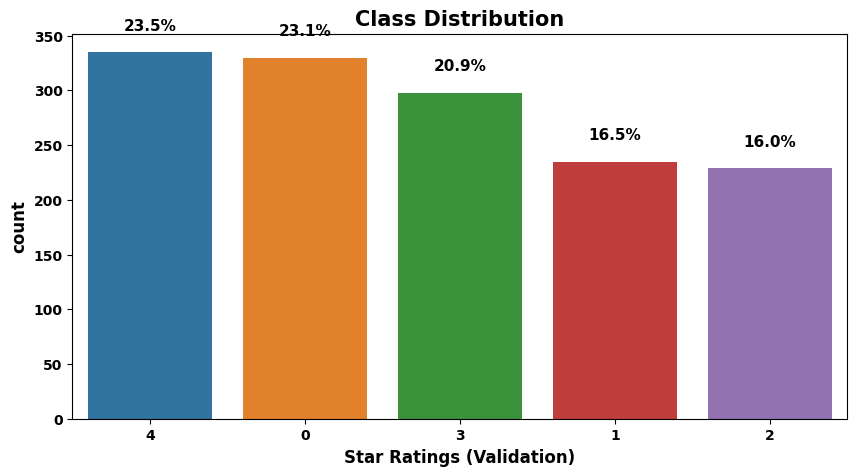

In [24]:
countplot(10,5,'label',15,0,'Star Ratings (Validation)','Class Distribution')

In [25]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [26]:
class Config:
    num_classes = 5
    path =  "xlm-roberta-base"
    num_epochs = 10
    batch_size = 32
    SEED = 42
    learning_rate = 2e-5
    device = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

In [27]:
tokenizer = AutoTokenizer.from_pretrained(config.path)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

<Axes: ylabel='Count'>

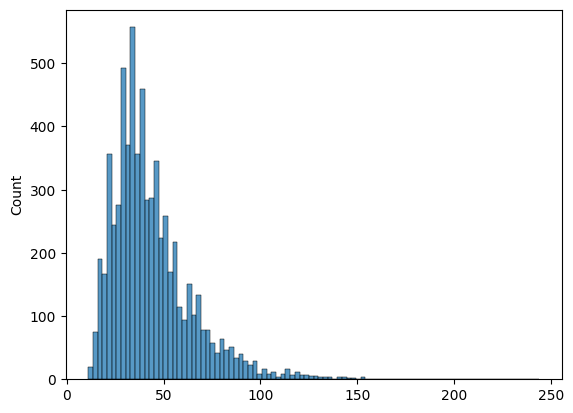

In [28]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

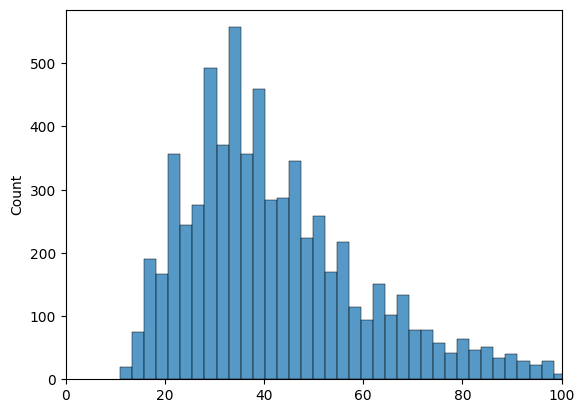

In [29]:
sns.histplot(token_counts)
plt.xlim([0, 100]);

<Axes: ylabel='Count'>

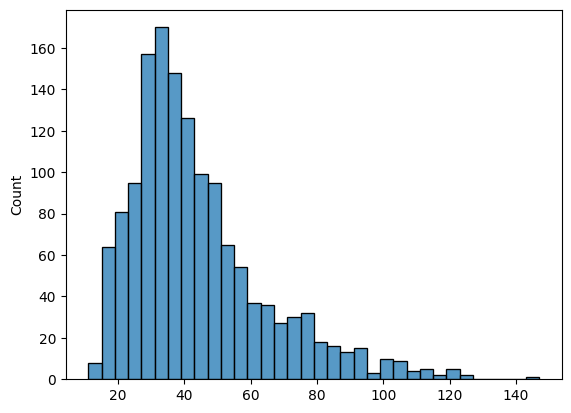

In [30]:
token_counts = []
for _, row in val_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [31]:
max(token_counts)

147

<Axes: ylabel='Count'>

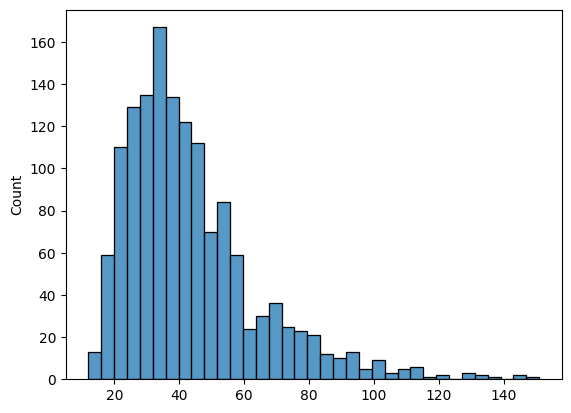

In [32]:
token_counts = []
for _, row in test_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [33]:
max(token_counts)

151

In [34]:
max_token_length = 120
def tokenize_function(example):
    return tokenizer(example["text"], padding = True, truncation=True, max_length=max_token_length)

# mapping dataset (actually texts) into tokenized values of pretrained model (provided in path)
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6660 [00:00<?, ? examples/s]

Map:   0%|          | 0/1427 [00:00<?, ? examples/s]

Map:   0%|          | 0/1428 [00:00<?, ? examples/s]

In [35]:
tokenized_train_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6660
})

In [36]:
tokenized_val_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1427
})

In [37]:
tokenized_test_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1428
})

In [38]:
'''XLM-R does not have token_type_ids, so don't need to remove them'''

# tokenized_train_datasets = tokenized_train_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['text'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['text'])
tokenized_test_datasets = tokenized_test_datasets.remove_columns(['text'])
tokenized_train_datasets.set_format("torch")
tokenized_val_datasets.set_format("torch")
tokenized_test_datasets.set_format("torch")

In [39]:
tokenized_test_datasets.column_names

['label', 'input_ids', 'attention_mask']

In [40]:
# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.bert = BertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes)

#     def forward(self, input_ids, attention_mask):
#         output = self.bert(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         x = self.drop(output[1])

#         return self.out(x)


'''XLNet Model'''
# from transformers import XLNetModel, XLNetTokenizer

# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.xlnet = XLNetModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.30)
#         self.out = nn.Linear(768, config.num_classes)  

#     def forward(self, input_ids, attention_mask):
#         # XLNet returns two outputs: the last hidden state and the pooled output (similar to BERT)
#         output = self.xlnet(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         # Take the first token's representation
#         cls_output = output.last_hidden_state[:, 0, :]  
#         x = self.drop(cls_output)

#         return self.out(x)


from transformers import XLMRobertaModel, XLMRobertaTokenizer, AdamW

'''XLM-R'''
class ClassifierModel(nn.Module):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained(config.path)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(768, config.num_classes)  

    def forward(self, input_ids, attention_mask):
        outputs = self.xlm_roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_output)
        return self.fc(x)

In [41]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score


class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        DEVICE = config.device
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(DEVICE)
            attention_mask = data["attention_mask"].to(DEVICE)            
            target = data["labels"].to(DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        DEVICE = config.device
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(DEVICE)
                attention_mask = data["attention_mask"].to(DEVICE)            
                target = data["labels"].to(DEVICE)
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [42]:
from transformers import get_scheduler

def run_training(save_model = False):

    train_loader = DataLoader(tokenized_train_datasets, batch_size = config.batch_size,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(tokenized_val_datasets, batch_size = config.batch_size,
                            drop_last=False,collate_fn=data_collator, shuffle=False, num_workers=2)   
    set_random_seed(config.SEED)
    model = ClassifierModel(config)
    model.to(config.device)
    
#     optimizer = create_optimizer(model)  
    optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate, weight_decay=0.01)
    num_training_steps = config.num_epochs * len(train_loader)
    
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.num_epochs):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Val_loss: {round(val_loss,5)} | Val_Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            
            if save_model:
                torch.save(model.state_dict(),f"xlmr_model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [43]:
score = run_training(save_model = True)
print(f"Best Score: {score}")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 1 | Training_loss: 0.8943 | Val_loss: 0.34247 | Val_Score: 0.86304


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 2 | Training_loss: 0.29358 | Val_loss: 0.21594 | Val_Score: 0.90473


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e71cb925f30>Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in 

 Epoch: 3 | Training_loss: 0.20252 | Val_loss: 0.21325 | Val_Score: 0.91073


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 4 | Training_loss: 0.1457 | Val_loss: 0.20191 | Val_Score: 0.91067


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 5 | Training_loss: 0.09964 | Val_loss: 0.2343 | Val_Score: 0.91105


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 6 | Training_loss: 0.0769 | Val_loss: 0.23435 | Val_Score: 0.92052


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 7 | Training_loss: 0.05498 | Val_loss: 0.2541 | Val_Score: 0.91048


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 8 | Training_loss: 0.04174 | Val_loss: 0.24902 | Val_Score: 0.91291


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 9 | Training_loss: 0.0299 | Val_loss: 0.25769 | Val_Score: 0.91017


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/45 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 10 | Training_loss: 0.02417 | Val_loss: 0.25465 | Val_Score: 0.91421
Best Score: 0.9205238916244793


In [44]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)

In [45]:
device = config.device

In [46]:
model = ClassifierModel(config)

In [47]:
model_path = f"/kaggle/working/xlmr_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [48]:
model.to(device)

ClassifierModel(
  (xlm_roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [49]:
model.eval()
prediction = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
        logits = outputs
        pred = torch.argmax(logits, dim=-1)
        prediction.extend(pred.cpu().numpy().tolist())

In [50]:
y_true = test_df.label.values
y_pred = prediction

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_true, y_pred))

[[321   7   2   0   0]
 [ 13 207  12   2   0]
 [  2  14 192  21   0]
 [  0   0  14 284   1]
 [  0   0   0  12 324]]


In [52]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

print("Model: XLMR")

# Print metrics
print("Weighted F1 Score:", weighted_f1)
print("Macro F1 Score:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Macro Precision:", macro_precision)
print("Weighted Recall:", weighted_recall)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       330
           1       0.91      0.88      0.90       234
           2       0.87      0.84      0.86       229
           3       0.89      0.95      0.92       299
           4       1.00      0.96      0.98       336

    accuracy                           0.93      1428
   macro avg       0.92      0.92      0.92      1428
weighted avg       0.93      0.93      0.93      1428

Confusion Matrix:
 [[321   7   2   0   0]
 [ 13 207  12   2   0]
 [  2  14 192  21   0]
 [  0   0  14 284   1]
 [  0   0   0  12 324]]
Model: XLMR
Weighted F1 Score: 0.929864050548586
Macro F1 Score: 0.9229456786508253
Weighted Precision: 0.9304833909183337
Macro Precision: 0.9246368722022078
Weighted Recall: 0.9299719887955182
Macro Recall: 0.9219778190292715
Accuracy: 0.9299719887955182


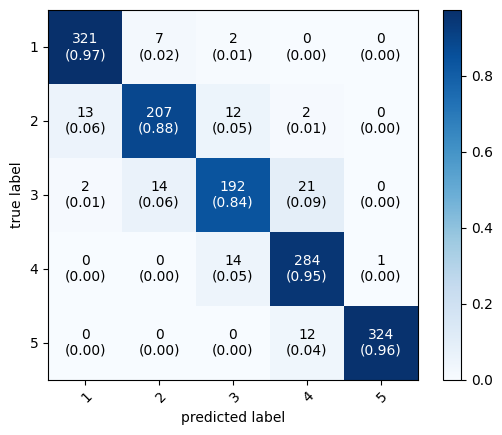

In [53]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes=5)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=[1,2,3,4,5],
                                show_normed=True,
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()